In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

In [5]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs',origin=url,extract=True)
file_path = os.path.join(os.path.dirname(zip_path),'cats_and_dogs_filtered')

train_dir = os.path.join(file_path,'train')
validation_dir = os.path.join(file_path,'validation')

68606236/68606236 [==============================] - 1s 0us/step


In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(160,160))

Found 2000 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=32,
                                                                 image_size=(160,160))

Found 1000 files belonging to 2 classes.


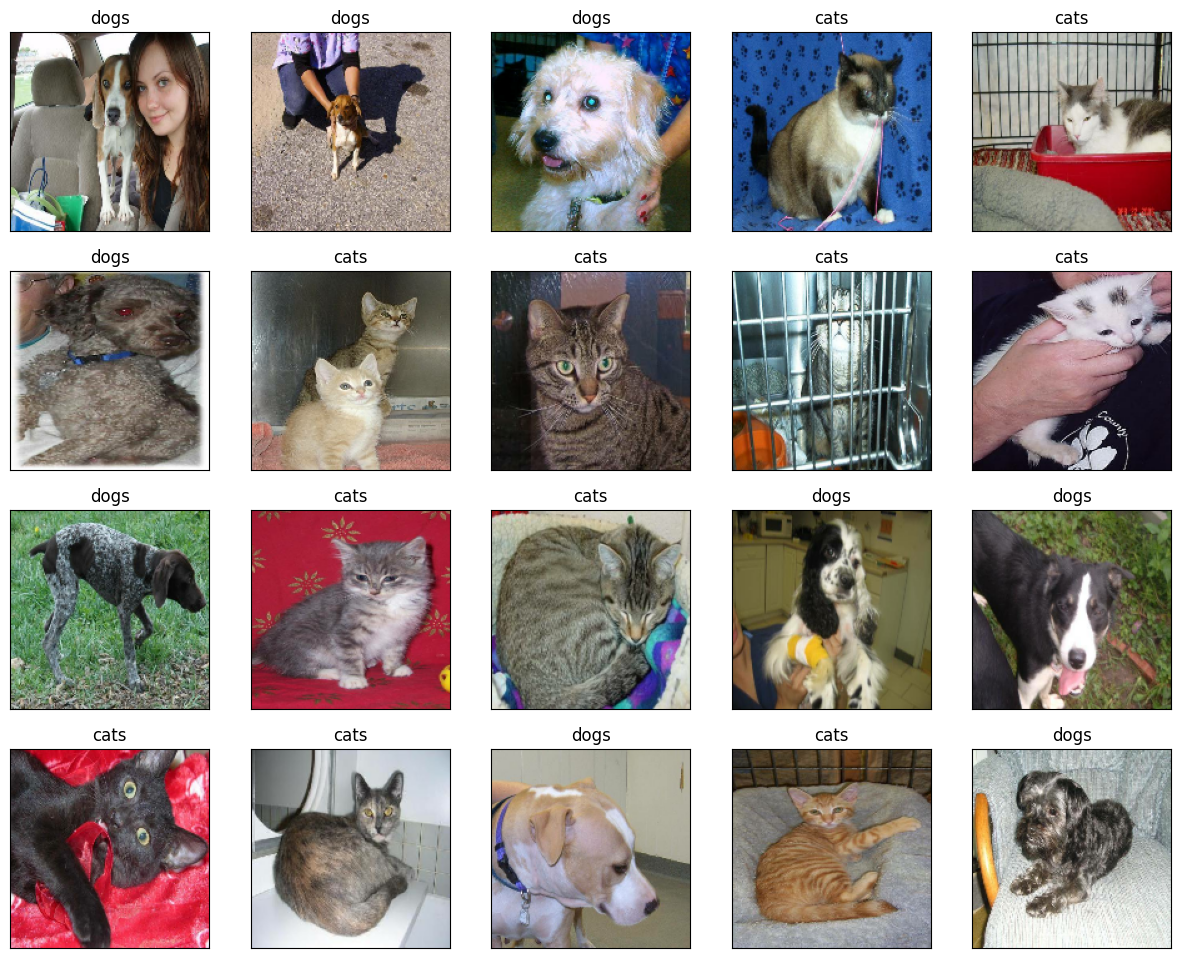

In [8]:
class_names = train_dataset.class_names
plt.figure(figsize=(15,15))
for image,labels in train_dataset.take(1):
  for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])

- Check the number of batches
- divide the validation_dataset into test_dataset and validation set
- here we are taking 1/5th of data from the validation_dataset
- And update the validation dataset

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

- insted of writing tf.data.experimental.cardinality(validaton_dataset)
- you can simply get above answers by  using this codes:
- print('Number of validation batches',len(validation_dataset))
- print('Number of test batches',len(test_dataset))

In [10]:
print('Number of validation batches : %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches : %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches : 26
Number of test batches : 6


Configure the dataset for the performance

In [11]:
autotune = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

**Data Agumentation**
- use when image dataset is not large
- it will take the images at all posiblites to train the model [ex:rotation,flipping,cutting ect,]

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

repetedly apply the same layers to see the results

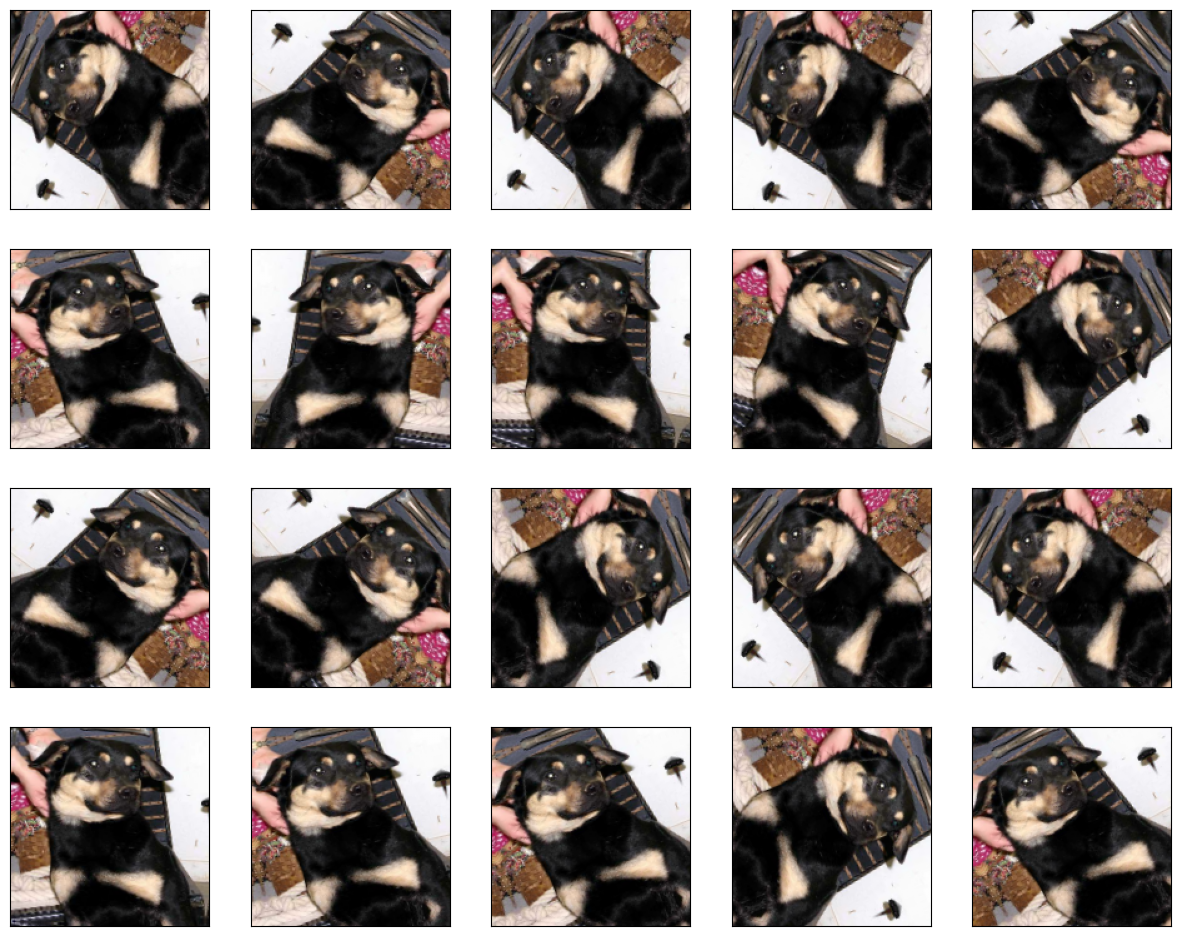

In [13]:
for image,_ in train_dataset.take(1):
  plt.figure(figsize=(15,15))
  first_image = image[0]
  for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0] / 255)

Rescale the pixel values

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

N

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5,offset=-1)

Create the base model from the pre-trained model MobileNet V2

In [16]:
img_shape = (160,160) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch =prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [24]:
len(model.trainable_variables)

2

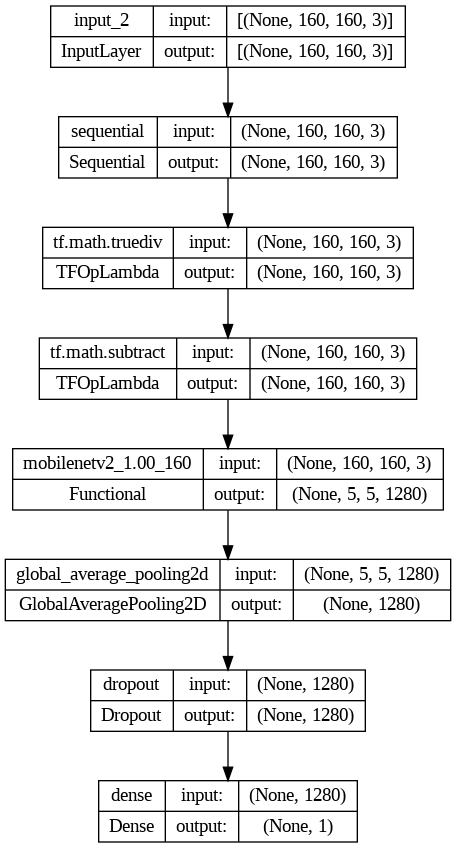

In [25]:
tf.keras.utils.plot_model(model,show_shapes=True)

**Compile the model**

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0,name='accuracy')])


**Train the model**

In [27]:
intial_epochs = 10
loss0,accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 16s 531ms/step - loss: 0.7620 - accuracy: 0.5507


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.55


In [29]:
history = model.fit(train_dataset,
                    epochs=intial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 57s 833ms/step - loss: 0.6793 - accuracy: 0.6285 - val_loss: 0.4855 - val_accuracy: 0.7970
Epoch 2/10
63/63 [==============================] - 59s 941ms/step - loss: 0.4933 - accuracy: 0.7605 - val_loss: 0.3638 - val_accuracy: 0.8837
Epoch 3/10
63/63 [==============================] - 59s 943ms/step - loss: 0.3988 - accuracy: 0.8345 - val_loss: 0.2817 - val_accuracy: 0.9344
Epoch 4/10
63/63 [==============================] - 60s 947ms/step - loss: 0.3426 - accuracy: 0.8730 - val_loss: 0.2305 - val_accuracy: 0.9505
Epoch 5/10
63/63 [==============================] - 62s 984ms/step - loss: 0.3160 - accuracy: 0.8805 - val_loss: 0.1975 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 59s 936ms/step - loss: 0.2871 - accuracy: 0.8905 - val_loss: 0.1676 - val_accuracy: 0.9641
Epoch 7/10
63/63 [==============================] - 59s 938ms/step - loss: 0.2521 - accuracy: 0.9085 - val_loss: 0.1509 - val_accuracy: 0.9678

**Learning Curves**

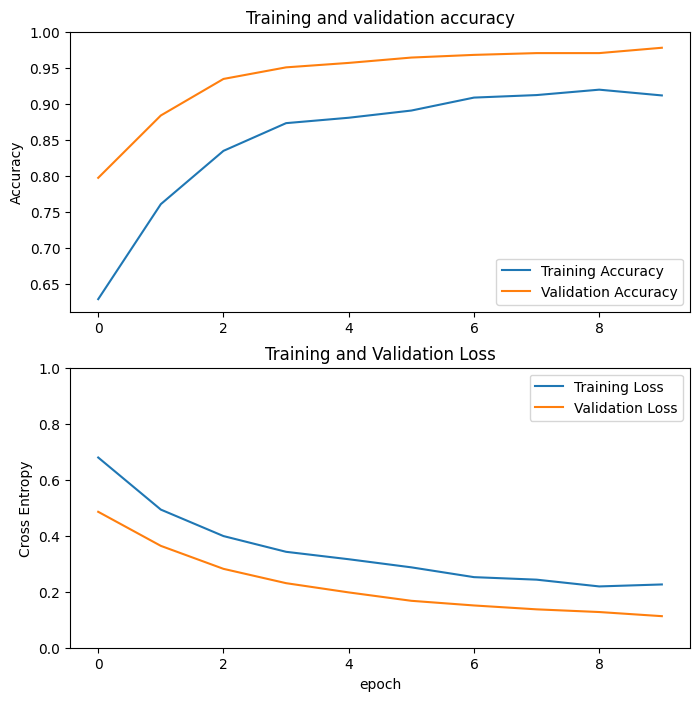

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and validation accuracy')

plt.subplot(2,1,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning the model**

In [31]:
# check how many layers are in the base model
print('The layers in the base are',len(base_model.layers))

# Fine tune from this layer
fine_tune = 100

# Freeze all the layers
for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

The layers in the base are 154


**Compile the model**

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [34]:
len(model.trainable_variables)

2

In [35]:
fine_tune_epochs = 10
total_epochs =  intial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 63s 946ms/step - loss: 0.2020 - accuracy: 0.9265 - val_loss: 0.1168 - val_accuracy: 0.9728
Epoch 11/20
63/63 [==============================] - 59s 931ms/step - loss: 0.1973 - accuracy: 0.9245 - val_loss: 0.1168 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 59s 933ms/step - loss: 0.2098 - accuracy: 0.9205 - val_loss: 0.1155 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 59s 934ms/step - loss: 0.2053 - accuracy: 0.9255 - val_loss: 0.1128 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 58s 927ms/step - loss: 0.2109 - accuracy: 0.9180 - val_loss: 0.1126 - val_accuracy: 0.9715
Epoch 15/20
63/63 [==============================] - 59s 933ms/step - loss: 0.2062 - accuracy: 0.9195 - val_loss: 0.1091 - val_accuracy: 0.9728
Epoch 16/20
63/63 [==============================] - 59s 934ms/step - loss: 0.1995 - accuracy: 0.9230 - val_loss: 0.1125 - val_accuracy:

In [37]:
acc +=history_fine.history['accuracy']
val_acc +=history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

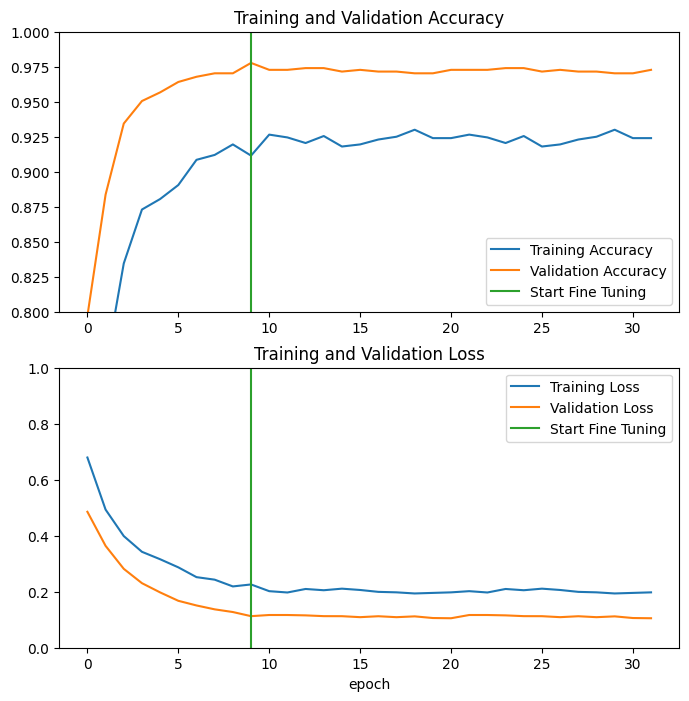

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([intial_epochs-1,intial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([intial_epochs-1,intial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Model Evaluation and Prediction**

In [45]:
loss,accuracy = model.evaluate(test_dataset)
print('Test ccuracy',accuracy)

6/6 [==============================] - 5s 746ms/step - loss: 0.1087 - accuracy: 0.9740
Test ccuracy 0.9739583134651184


**Predictions**

predictions:
 [0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1]
Labels:
 tf.Tensor([1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0], shape=(32,), dtype=int32)


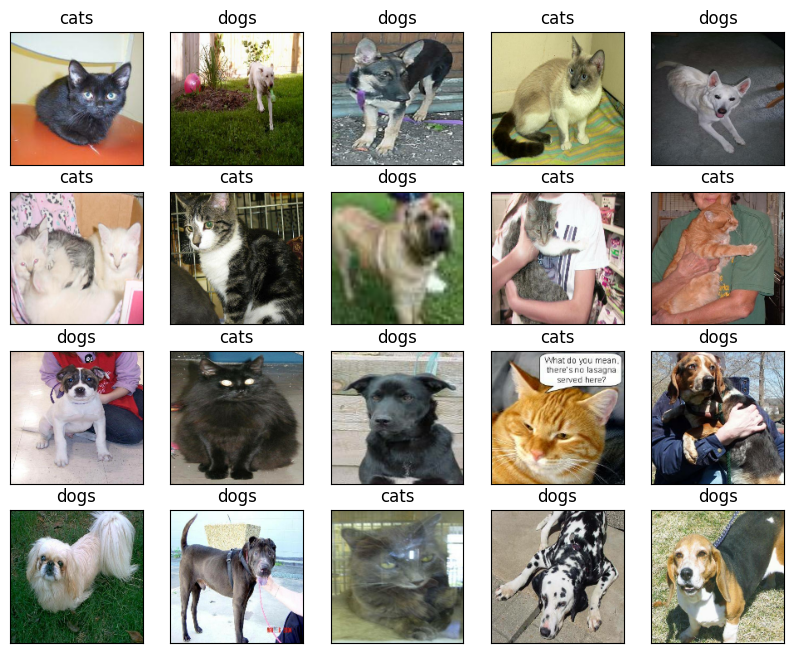

In [46]:
# Taka a batch of images from the test data
image_batch,lael_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5,0,1)

print('predictions:\n',predictions.numpy())
print('Labels:\n',label_batch)

plt.figure(figsize=(10,10))
for i in range(20):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image_batch[i].astype('uint8'))
  plt.title(class_names[predictions[i]])